# Linear Models

### These are available Linear Models

In [14]:
regressor_models = [
    'ARDRegression',
    'BayesianRidge',
    'ElasticNet',
    'ElasticNetCV',
    'GammaRegressor',
    'HuberRegressor',
    'Lars',
    'LarsCV',
    'Lasso',
    'LassoCV',
    'LassoLars',
    'LassoLarsCV',
    'LassoLarsIC',
    'LinearRegression',
    'OrthogonalMatchingPursuit',
    'PassiveAggressiveRegressor',
    'PoissonRegressor',
    'QuantileRegressor',
    'RANSACRegressor',
    'Ridge',
    'RidgeCV',
    'SGDRegressor',
    'TheilSenRegressor',
    'TweedieRegressor']

classifier_models = [
    'LogisticRegression',
    'LogisticRegressionCV',
    'PassiveAggressiveClassifier',
    'Perceptron',
    'RidgeClassifier',
    'RidgeClassifierCV',
    'SGDClassifier']

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import plot_confusion_matrix
from time import time
from datetime import timedelta

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [16]:
def data_loader(filepath, test_size=0.3, train_size=None,
                random_state=None, shuffle=True, encode=False):
    """
    filepath:     <str>
        path of .csv dataset file
    
    test_size:    <float> [0.0, 1.0], default=0.3
        the proportion of the dataset to include in the test
    
    train_size:   <float> [0.0, 1.0], default=None
        the proportion of the dataset to include in the train
        * if train_size is given, test_size will not be used
    
    random_state: <int>,  default=None
        controls the shuffling applied to the data 
        before applying the split
    
    shuffle:      <bool>, default=True
        whether or not to shuffle the data before splitting
    
    encoded:      <bool>, default=True
    
    """
    dataset = pd.read_csv(filepath)
    X = dataset.iloc[:, :-1].values
    Y = dataset.iloc[:, -1].values

    encoder = None

    if encode:
        X, _ = one_hot_encoder(X)
        Y, encoder = one_hot_encoder(Y)

    if train_size is None:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    else:
        X_train, X_test, Y_train, y_test = train_test_split(
            X, Y, train_size=train_size, random_state=random_state, shuffle=shuffle)
    return X_train, X_test, Y_train, Y_test, encoder

In [17]:
def scaler(scaler_type, train, test):
    """
    scaler_type: <str>
        type of scaler in sklearn.preprocessing
    train:       <numpy.ndarray>
        train dataset that needs to be scaled
    test:        <numpy.ndarray>
        test  dataset that needs to be scaled
    """
    string_mapping = dict()
    for i in range(train.shape[1]):
        if isinstance(train[:, i][0], str):
            classes = list(set(train[:, i]))
            mapping = dict()
            for j in range(len(classes)):
                mapping[classes[j]] = j
            string_mapping[i] = mapping
            for k in range(train.shape[0]):
                train[k][i] = mapping[train[k][i]]
            for l in range(test.shape[0]):
                test[l][i] = mapping[test[l][i]]
    sc = eval('sklearn.preprocessing.'+scaler_type)()
    train = sc.fit_transform(train)
    test  = sc.transform(test)
    return train, test

In [18]:
def one_hot_encoder(dataset):
    """
    dataset: <np.ndarray>
        the dataset array which string features are to be encoded
    
    return: encoded dataset, encoder
        there can be a need to inverse the encoded data,
        that's why encoder is returned as well
    """
    string_cloumns = list()
    for i in range(dataset[0]):
        if isinstance(dataset[0, i], str):
            string_cloumns.append(i)
    if string_cloumns == list():
        return dataset, None
    encoder = ColumnTransformer(
        [('encoder', OneHotEncoder(sparse=False), string_cloumns)], remainder='passthrough')
    
    return np.array(encoder.fit_transform(dataset), dtype=float), encoder

In [19]:
def linear_model(model_type):
    """
    model_type: <str>
        name of linear model in sklearn.linear_model
    """
    return eval('sklearn.linear_model.' + model_type)

In [20]:
def model_fit(model_type, train, target):
    """
    model_type: <str>
        name of linear model in sklearn.linear_model
    
    train:      <numpy.ndarray>
        train dataset used for fitting the model
    
    target:     <numpy.ndarray>
        target dataset used fot fitting the model
    """
    model = linear_model(model_type)()
    return model.fit(train, target)

In [21]:
def predict(model, test):
    """
    model:
        trained linear model
    
    test: <numpy.ndarray>
        test dataset used for evaluation of the model
    """
    return model.predict(test)

In [22]:
def model_eval(model, x_test, y_test, eval_type='accuracy_score'):
    pred = predict(model, x_test)
    return eval('sklearn.metrics.'+eval_type)(y_test, pred)

In [23]:
def plot(plot_type, **args):
    if plot_type in ['scatter', 'plot']:
        eval('plt.'+plot_type)(args['x'], args['y'], color=args['color'])

In [24]:
def exec_time(st_time):
    return str(timedelta(seconds=time() - st_time))

In [25]:
def linear_model_main(model_type, filepath, test_size=0.3, train_size=None,
                      random_state=None, shuffle=True, encode=False,
                      scaler_type=None, eval_type=None, plot_type=None):
    st_time = time()

    # data preparation
    x_train, x_test, y_train, y_test, encoder = data_loader(
        filepath, test_size, train_size, random_state, shuffle, encode)
    
    # scaling
    if scaler_type:
        x_train, x_test = scaler(scaler_type, x_train, x_test)
    
    # model fitting
    model = model_fit(model_type, x_train, y_train)
    
    # plotting
    if plot_type:
        if plot_type != 'confusion_matrix':
            pred_test = predict(model, x_test)
            plot('scatter', x=x_test, y=y_test, color='red')
            plot('plot', x=x_test, y=pred_test, color='blue')
            plt.show()
        else:
            plot_confusion_matrix(model, x_test, y_test)
            plt.show()
    
    # evaluation
    if eval_type:
        accuracy = model_eval(model, x_test, y_test, eval_type)
        print(f'{eval_type}:\n{accuracy}')

    print(f'Execution_time:', exec_time(st_time))

    if encode:
        return model, encoder
    
    return model

### Testing all available Classification Linear Models


[LogisticRegression]


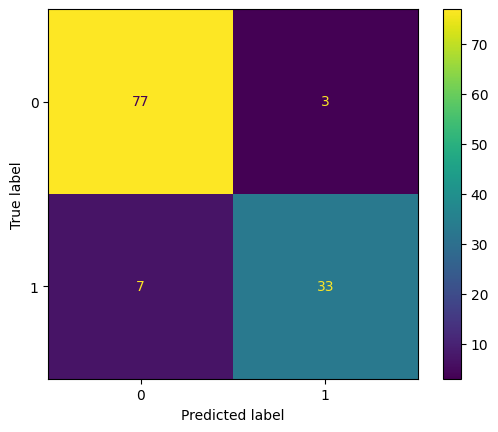

accuracy_score:
0.9166666666666666
Execution_time: 0:00:00.141994

[LogisticRegressionCV]


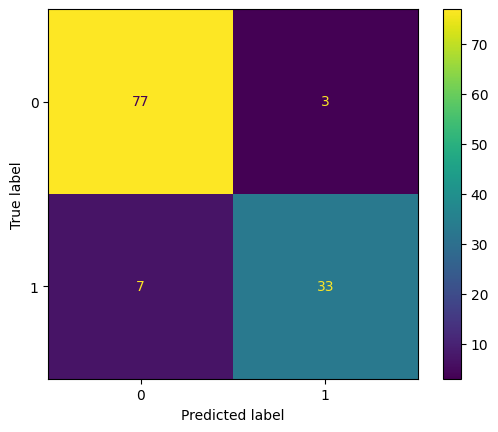

accuracy_score:
0.9166666666666666
Execution_time: 0:00:00.162729

[PassiveAggressiveClassifier]


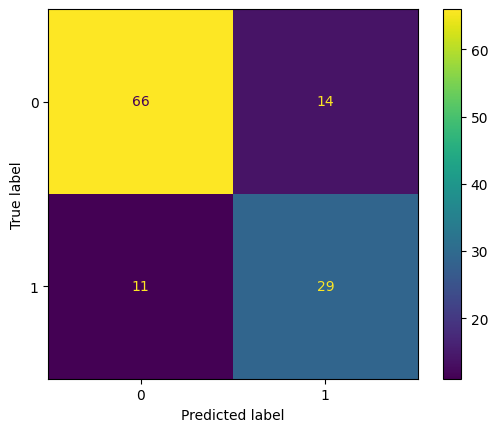

accuracy_score:
0.7916666666666666
Execution_time: 0:00:00.103775

[Perceptron]


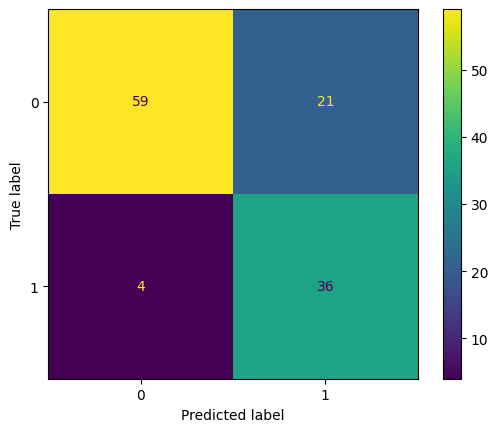

accuracy_score:
0.7916666666666666
Execution_time: 0:00:00.100946

[RidgeClassifier]


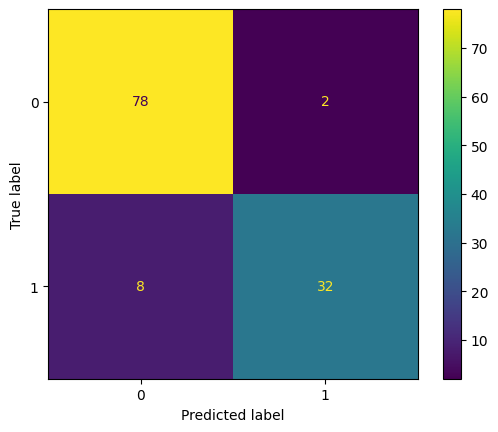

accuracy_score:
0.9166666666666666
Execution_time: 0:00:00.108725

[RidgeClassifierCV]


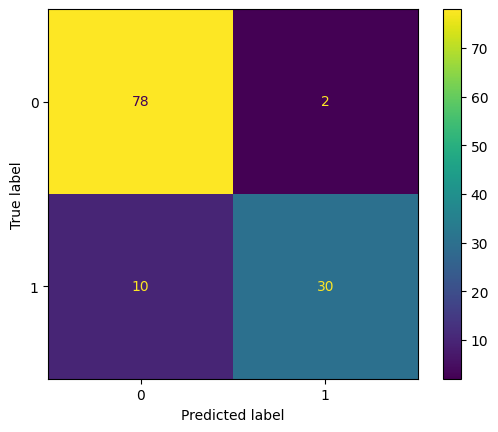

accuracy_score:
0.9
Execution_time: 0:00:00.110083

[SGDClassifier]


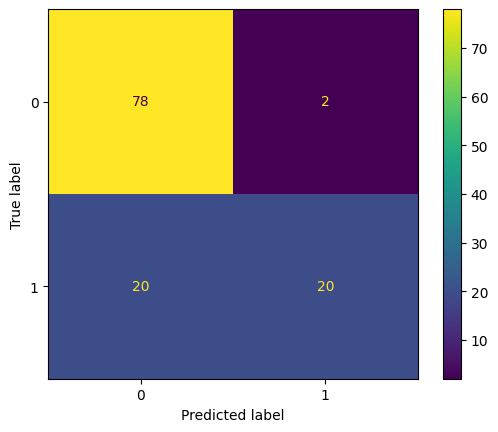

accuracy_score:
0.8166666666666667
Execution_time: 0:00:00.108319


In [26]:
# parameters
for cls in classifier_models:
    model_type = cls
    print(f'\n[{model_type}]')
    filepath = '../dataset/Social_Network_Ads.csv'
    test_size = 0.3
    train_size = None
    random_state = 76
    shuffle = True
    scaler_type = 'StandardScaler'
    eval_type = 'accuracy_score'
    plot_type = 'confusion_matrix'
    encode = False

    model = linear_model_main(model_type, filepath, test_size,
                              train_size, random_state, shuffle, encode,
                              scaler_type, eval_type, plot_type)

### Testing all available Regression Linear Models


[ARDRegression]


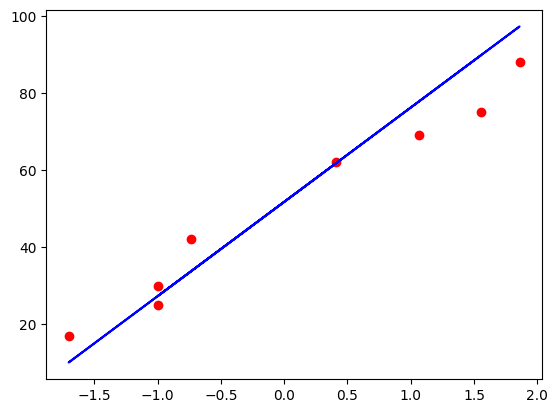

mean_squared_error:
63.60914904246342
Execution_time: 0:00:00.094498

[BayesianRidge]


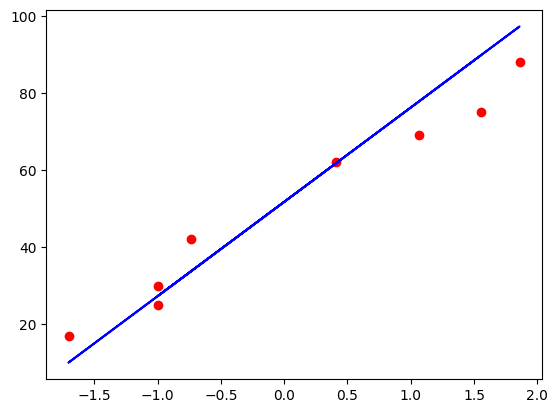

mean_squared_error:
63.609149042463464
Execution_time: 0:00:00.096589

[ElasticNet]


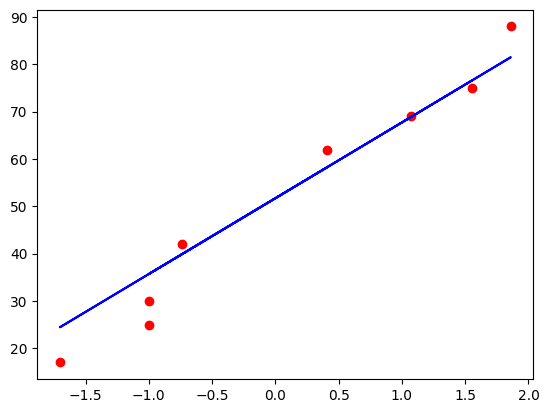

mean_squared_error:
33.20250408038419
Execution_time: 0:00:00.100331

[ElasticNetCV]


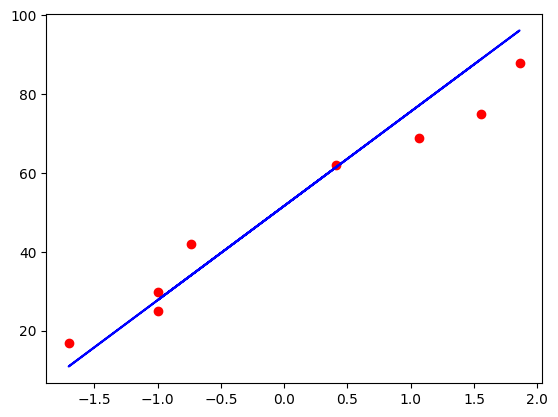

mean_squared_error:
54.70118200845634
Execution_time: 0:00:00.124875

[GammaRegressor]


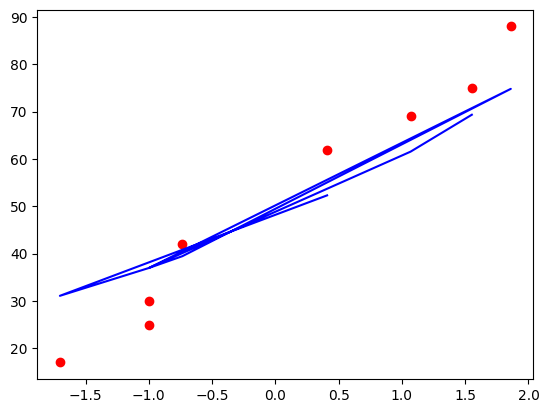

mean_squared_error:
93.97282147568632
Execution_time: 0:00:00.100289

[HuberRegressor]


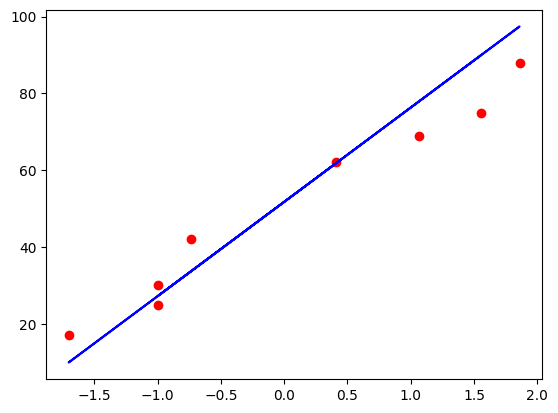

mean_squared_error:
65.26731548450891
Execution_time: 0:00:00.093016

[Lars]


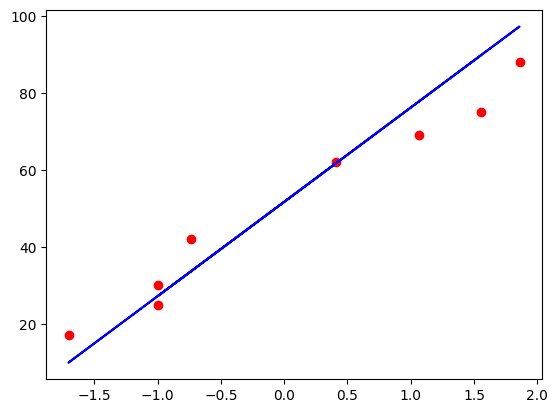

mean_squared_error:
64.56159752115113
Execution_time: 0:00:00.171249

[LarsCV]


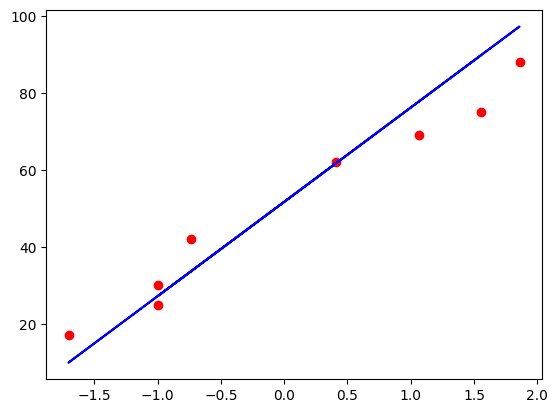

mean_squared_error:
64.56159752115113
Execution_time: 0:00:00.092073

[Lasso]


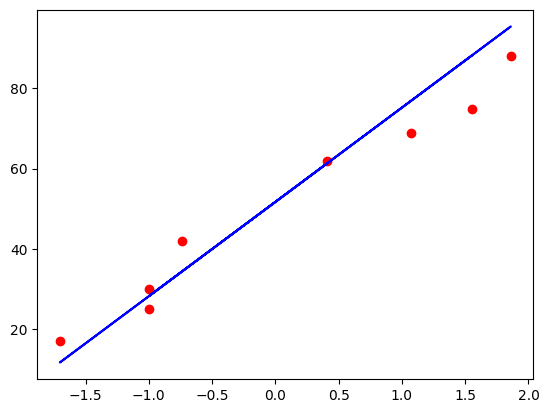

mean_squared_error:
49.03843570965044
Execution_time: 0:00:00.086613

[LassoCV]


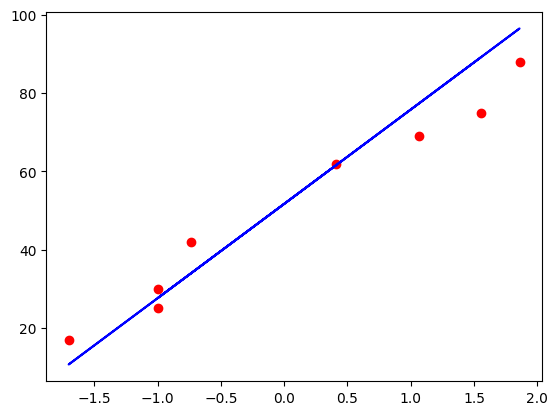

mean_squared_error:
57.52226176855174
Execution_time: 0:00:00.129578

[LassoLars]


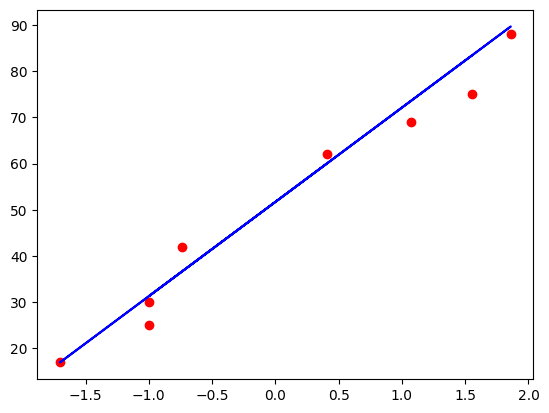

mean_squared_error:
20.858650164379767
Execution_time: 0:00:00.104228

[LassoLarsCV]


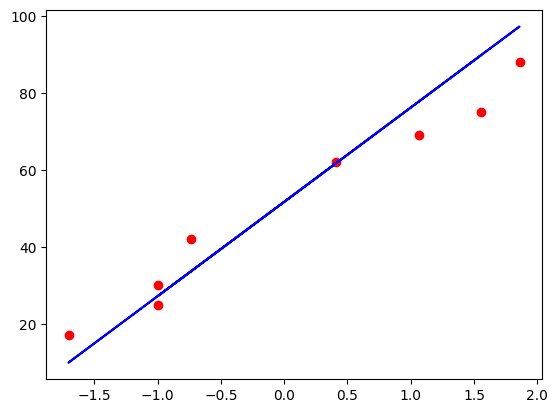

mean_squared_error:
64.56159752115113
Execution_time: 0:00:00.092550

[LassoLarsIC]


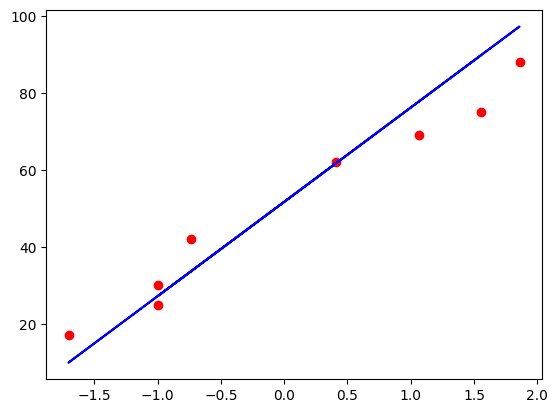

mean_squared_error:
64.56159752115113
Execution_time: 0:00:00.094213

[LinearRegression]


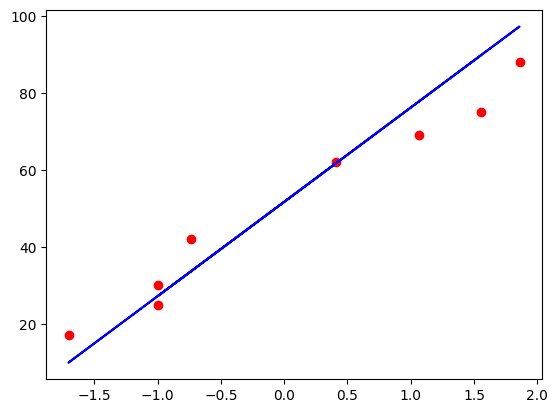

mean_squared_error:
64.56159752115124
Execution_time: 0:00:00.089386

[OrthogonalMatchingPursuit]


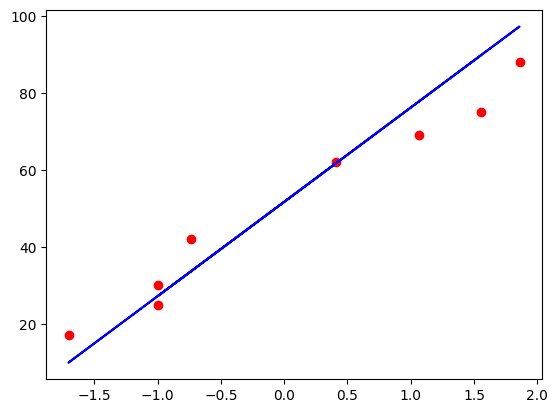

mean_squared_error:
64.56159752115113
Execution_time: 0:00:00.086451

[PassiveAggressiveRegressor]


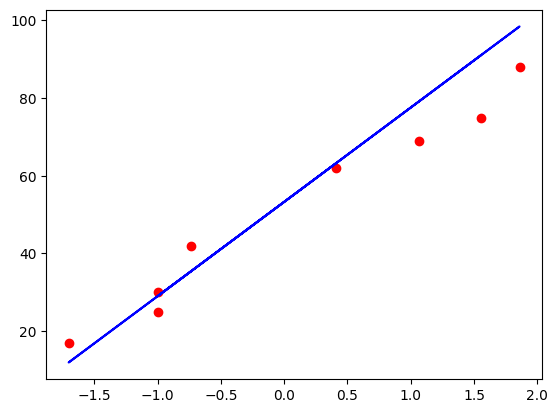

mean_squared_error:
69.53593661705291
Execution_time: 0:00:00.093055

[PoissonRegressor]


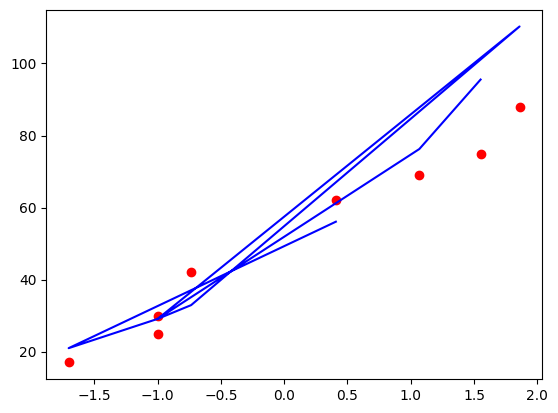

mean_squared_error:
140.13451037405886
Execution_time: 0:00:00.116815

[QuantileRegressor]


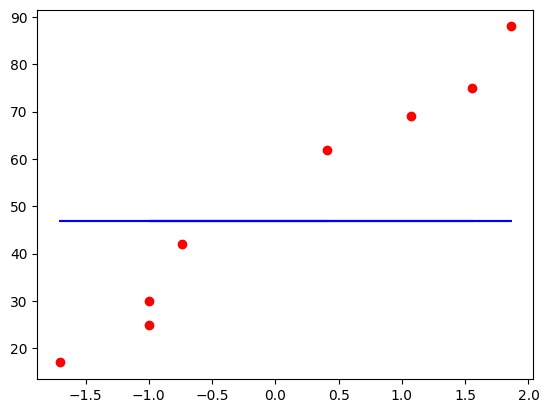

mean_squared_error:
609.000000030867
Execution_time: 0:00:00.100677

[RANSACRegressor]


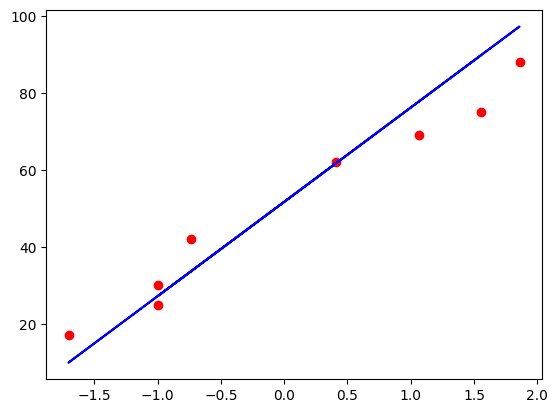

mean_squared_error:
64.56159752115124
Execution_time: 0:00:00.092947

[Ridge]


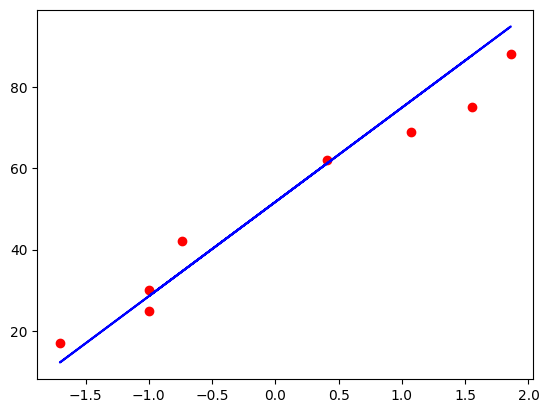

mean_squared_error:
44.18914329837723
Execution_time: 0:00:00.085054

[RidgeCV]


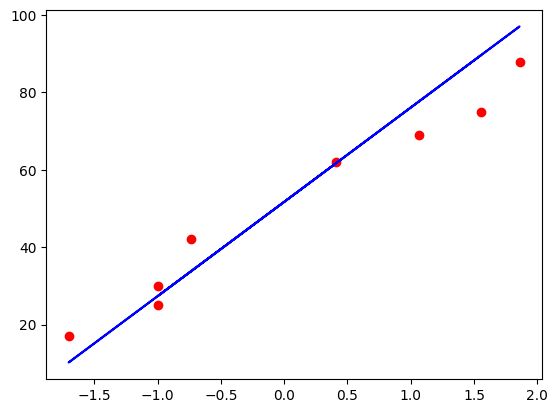

mean_squared_error:
62.14146203556578
Execution_time: 0:00:00.090191

[SGDRegressor]


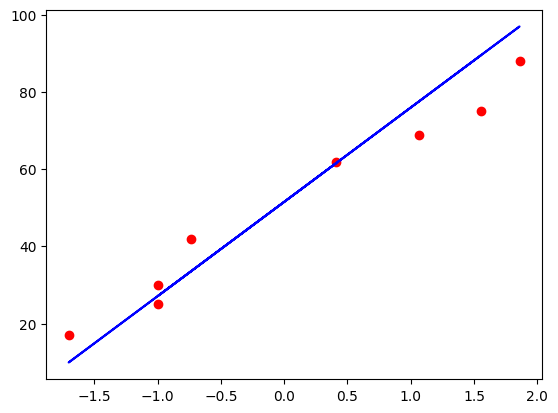

mean_squared_error:
62.507304201831246
Execution_time: 0:00:00.093282

[TheilSenRegressor]


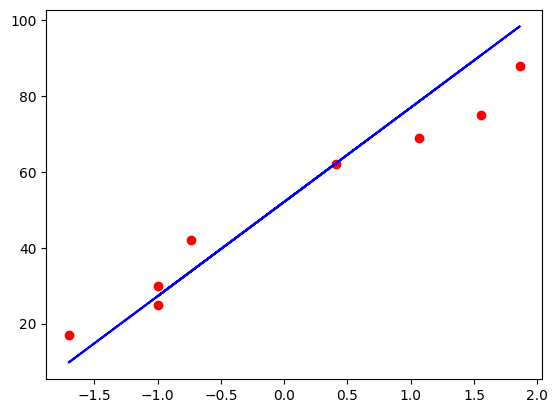

mean_squared_error:
71.94976334170481
Execution_time: 0:00:00.093025

[TweedieRegressor]


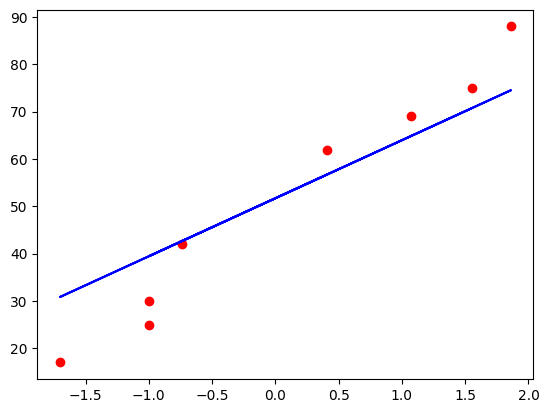

mean_squared_error:
91.94853266559144
Execution_time: 0:00:00.108137


In [27]:
# parameters
for reg in regressor_models:
    model_type = reg
    print(f'\n[{model_type}]')
    filepath = '../dataset/studentscores.csv'
    test_size = 0.3
    train_size = None
    random_state = 76
    shuffle = True
    encode = False
    scaler_type = 'StandardScaler'
    eval_type = 'mean_squared_error'
    plot_type = True

    model = linear_model_main(model_type, filepath, test_size,
                              train_size, random_state, shuffle, encode,
                              scaler_type, eval_type, plot_type)